# Training ResTS Model for Plant Disease Detection

This notebook implements the training process for the **ResTS** model to detect plant diseases using the **PlantVillage** dataset. The ResTS model is a Teacher-Student architecture with interpretable layers, based on the Xception architecture.

### Objectives:
- Load and preprocess the dataset
- Define the ResTS model
- Train the model using GPU acceleration
- Save the model weights and training results

In [1]:
# Import required libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, SeparableConv2D, BatchNormalization, Activation, Add, UpSampling2D, Reshape, ZeroPadding2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Verifica se a GPU está disponível
print("TensorFlow version:", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

tf.config.optimizer.set_jit(True)  # Habilita o compilador XLA

TensorFlow version: 2.4.1
GPU is available


In [3]:
# Main parameters
input_shape = (224, 224, 3)
num_classes = 38  # number of classes in the PlantVillage dataset
batch_size = 8
epochs = 15

# Data directories
TRAINING_DIR = '../data/train/'
VALIDATION_DIR = '../data/val/'

In [4]:
# Data augmentation and preprocessing for training
training_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=tf.keras.applications.xception.preprocess_input
)

# Preprocessing for validation
validation_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.xception.preprocess_input)

# Data generators
train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True
)

Found 37997 images belonging to 38 classes.
Found 8129 images belonging to 38 classes.


In [ ]:
# Encoder Start (based on Xception)
base_model1 = tf.keras.applications.Xception(include_top=False, weights='imagenet', input_shape=input_shape)
x1_0 = Flatten(name='Flatten1')(base_model1.output)
dense1 = Dense(256, activation='relu', name='fc1')(x1_0)
x = classif_out_encoder1 = Dense(num_classes, activation='softmax', name='out1')(dense1)  # Encoder output

#Get Xception's tensors for skip connection.
conv14 = base_model1.get_layer('block14_sepconv2_act').output
conv13 = base_model1.get_layer('block13_sepconv2_bn').output
conv12 = base_model1.get_layer('block12_sepconv3_bn').output
conv11 = base_model1.get_layer('block11_sepconv3_bn').output
conv10 = base_model1.get_layer('block10_sepconv3_bn').output
conv9 = base_model1.get_layer('block9_sepconv3_bn').output
conv8 = base_model1.get_layer('block8_sepconv3_bn').output
conv7 = base_model1.get_layer('block7_sepconv3_bn').output
conv6 = base_model1.get_layer('block6_sepconv3_bn').output
conv5 = base_model1.get_layer('block5_sepconv3_bn').output
conv4 = base_model1.get_layer('block4_sepconv2_bn').output
conv3 = base_model1.get_layer('block3_sepconv2_bn').output
conv2 = base_model1.get_layer('block2_sepconv2_bn').output
conv1 = base_model1.get_layer('block1_conv2_act').output

# Decoder Start
dense2 = Dense(256, activation='relu')(x)
x = Add(name='first_merge')([dense1, dense2])
x = Dense(7 * 7 * 2048)(x)
reshape1 = Reshape((7, 7, 2048))(x)

#BLOCK 1
x = SeparableConv2D(2048, (3,3), padding='same', name='block14_start')(reshape1)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = concatenate([conv14, x], axis = 3)
x = SeparableConv2D(1536, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = c14 = Activation('relu')(x)

#BLOCK 2
x = UpSampling2D((2,2))(x)
x = Activation('relu')(x)
x = SeparableConv2D(1024, (3,3), padding='same', name='block13_start')(x)
x = BatchNormalization()(x)
x = concatenate([conv13, x], axis = 3)
x = Activation('relu')(x)
x = SeparableConv2D(728, (3,3), padding='same')(x)
x = BatchNormalization()(x)

c1314 = Conv2D(728, (1,1))(UpSampling2D()(c14))
x = add1 = Add()([c1314, x])

#BLOCK 3
x = Activation('relu')(x)
x = SeparableConv2D(728, (3,3), padding='same', name='blockmiddle_start')(x)
x = BatchNormalization()(x)
x = concatenate([conv12, x], axis = 3)
x = Activation('relu')(x)
x = SeparableConv2D(728, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(728, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = add2 = Add()([add1, x])
#BLOCK 4
x = Activation('relu')(x)
x = SeparableConv2D(728, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = concatenate([conv11, x], axis = 3)
x = Activation('relu')(x)
x = SeparableConv2D(728, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(728, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = add3 = Add()([add2, x])
#BLOCK 5
x = Activation('relu')(x)
x = SeparableConv2D(728, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = concatenate([conv10, x], axis = 3)
x = Activation('relu')(x)
x = SeparableConv2D(728, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(728, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = add4 = Add()([add3, x])
#BLOCK 6
x = Activation('relu')(x)
x = SeparableConv2D(728, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = concatenate([conv9, x], axis = 3)
x = Activation('relu')(x)
x = SeparableConv2D(728, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(728, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = add5 = Add()([add4, x])
#BLOCK 7
x = Activation('relu')(x)
x = SeparableConv2D(728, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = concatenate([conv8, x], axis = 3)
x = Activation('relu')(x)
x = SeparableConv2D(728, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(728, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = add6 = Add()([add5, x])
#BLOCK 8
x = Activation('relu')(x)
x = SeparableConv2D(728, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = concatenate([conv7, x], axis = 3)
x = Activation('relu')(x)
x = SeparableConv2D(728, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(728, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = add7 = Add()([add6, x])
#BLOCK 9
x = Activation('relu')(x)
x = SeparableConv2D(728, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = concatenate([conv6, x], axis = 3)
x = Activation('relu')(x)
x = SeparableConv2D(728, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(728, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = add8 = Add()([add7, x])
#BLOCK 10
x = Activation('relu')(x)
x = SeparableConv2D(728, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = concatenate([conv5, x], axis = 3)
x = Activation('relu')(x)
x = SeparableConv2D(728, (3,3), padding='same', name ='blockmiddle_end')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(728, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = add9 = Add()([add8, x])

#BLOCK 11
x = UpSampling2D((2,2))(x)
x = Activation('relu')(x)
x = SeparableConv2D(728, (3,3), padding='same', name='block4_start')(x)
x = BatchNormalization()(x)
x = concatenate([conv4, x], axis = 3)
x = Activation('relu')(x)
x = SeparableConv2D(728, (3,3), padding='same')(x)
x = BatchNormalization()(x)

c45 = Conv2D(728, (1,1))(UpSampling2D()(add9))
x = add10 = Add()([c45, x])

#BLOCK 12
x = Conv2DTranspose(1, (3,3), strides=(2,2))(x)
x = Activation('relu')(x)
x = SeparableConv2D(256, (3,3), padding='valid', name='block3_start')(x)
x = BatchNormalization()(x)
x = concatenate([conv3, x], axis = 3)
x = Activation('relu')(x)
x = SeparableConv2D(256, (3,3), padding='same')(x)
x = BatchNormalization()(x)

c34 = Conv2D(256, (3,3), padding='valid')(Conv2DTranspose(1, (3,3), strides=(2,2))(add10))
x = add11 = Add()([c34, x])

#BLOCK 13
x = Conv2DTranspose(1, (3,3), strides=(2,2))(x)
x = Activation('relu')(x)
x = SeparableConv2D(128, (3,3), padding='valid', name='block2_start')(x)
x = BatchNormalization()(x)
x = concatenate([conv2, x], axis = 3)
x = Activation('relu')(x)
x = SeparableConv2D(128, (3,3), padding='same')(x)
x = BatchNormalization()(x)

c23 = Conv2D(128, (3,3), padding='valid')(Conv2DTranspose(1, (3,3), strides=(2,2))(add11))
x = add12 = Add()([c23, x])

#BLOCK 14
x = Conv2D(64, (3,3), padding='same', name='block1_start')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = concatenate([conv1, x], axis = 3)
x = ZeroPadding2D()(x)
x = Conv2D(32, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D()(x)
x = ZeroPadding2D()(x)

x = Conv2D(2, 3, activation = 'relu', padding = 'same',)(x)
mask = x = Conv2D(3, 1, activation = 'sigmoid',name='Mask')(x)

# Student Encoder
base_model2 = tf.keras.applications.Xception(include_top=False, weights='imagenet', input_shape=input_shape)
x2_0 = Flatten(name='Flatten2')(base_model2(x))
x2_1 = Dense(256, activation='relu', name='fc2')(x2_0)
classif_out_encoder2 = Dense(num_classes, activation='softmax', name='out2')(x2_1)

# Create ResTS Model
ResTS = Model(inputs=base_model1.input, outputs=[classif_out_encoder1, classif_out_encoder2])

# Compile the model
losses = {
    "out1": 'categorical_crossentropy',
    "out2": 'categorical_crossentropy'
}
alpha = 0.4
lossWeights = {"out1": alpha, "out2": 1.0 - alpha}

ResTS.compile(optimizer=SGD(learning_rate=1e-4, momentum=0.9),
              loss=losses,
              loss_weights=lossWeights,
              metrics=['accuracy'],
              run_eagerly=True)

ResTS.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [ ]:
# Train the ResTS model
history = ResTS.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

df = pd.DataFrame(history.history)
df.to_csv('../data/results/ResTS15epochs.csv', index=False)

# Save the trained model weights
ResTS.save('../data/models/ResTS_trained_model.h5', save_format='h5')

Epoch 1/15
4749/4749 [==============================] - 1689s 356ms/step - loss: 1.8618 - out1_loss: 1.7146 - out2_loss: 1.9599 - out1_accuracy: 0.5577 - out2_accuracy: 0.4806 - val_loss: 0.4777 - val_out1_loss: 0.4020 - val_out2_loss: 0.5283 - val_out1_accuracy: 0.8735 - val_out2_accuracy: 0.8348
Epoch 2/15
4749/4749 [==============================] - 1660s 349ms/step - loss: 0.5759 - out1_loss: 0.5016 - out2_loss: 0.6255 - out1_accuracy: 0.8424 - out2_accuracy: 0.8017 - val_loss: 0.3235 - val_out1_loss: 0.2835 - val_out2_loss: 0.3502 - val_out1_accuracy: 0.9060 - val_out2_accuracy: 0.8812
Epoch 3/15
4749/4749 [==============================] - 1658s 349ms/step - loss: 0.4026 - out1_loss: 0.3673 - out2_loss: 0.4262 - out1_accuracy: 0.8851 - out2_accuracy: 0.8642 - val_loss: 0.2496 - val_out1_loss: 0.2257 - val_out2_loss: 0.2655 - val_out1_accuracy: 0.9256 - val_out2_accuracy: 0.9146
Epoch 4/15
4749/4749 [==============================] - 1660s 350ms/step - loss: 0.3286 - out1_loss: 0.

OSError: Unable to create link (name already exists)

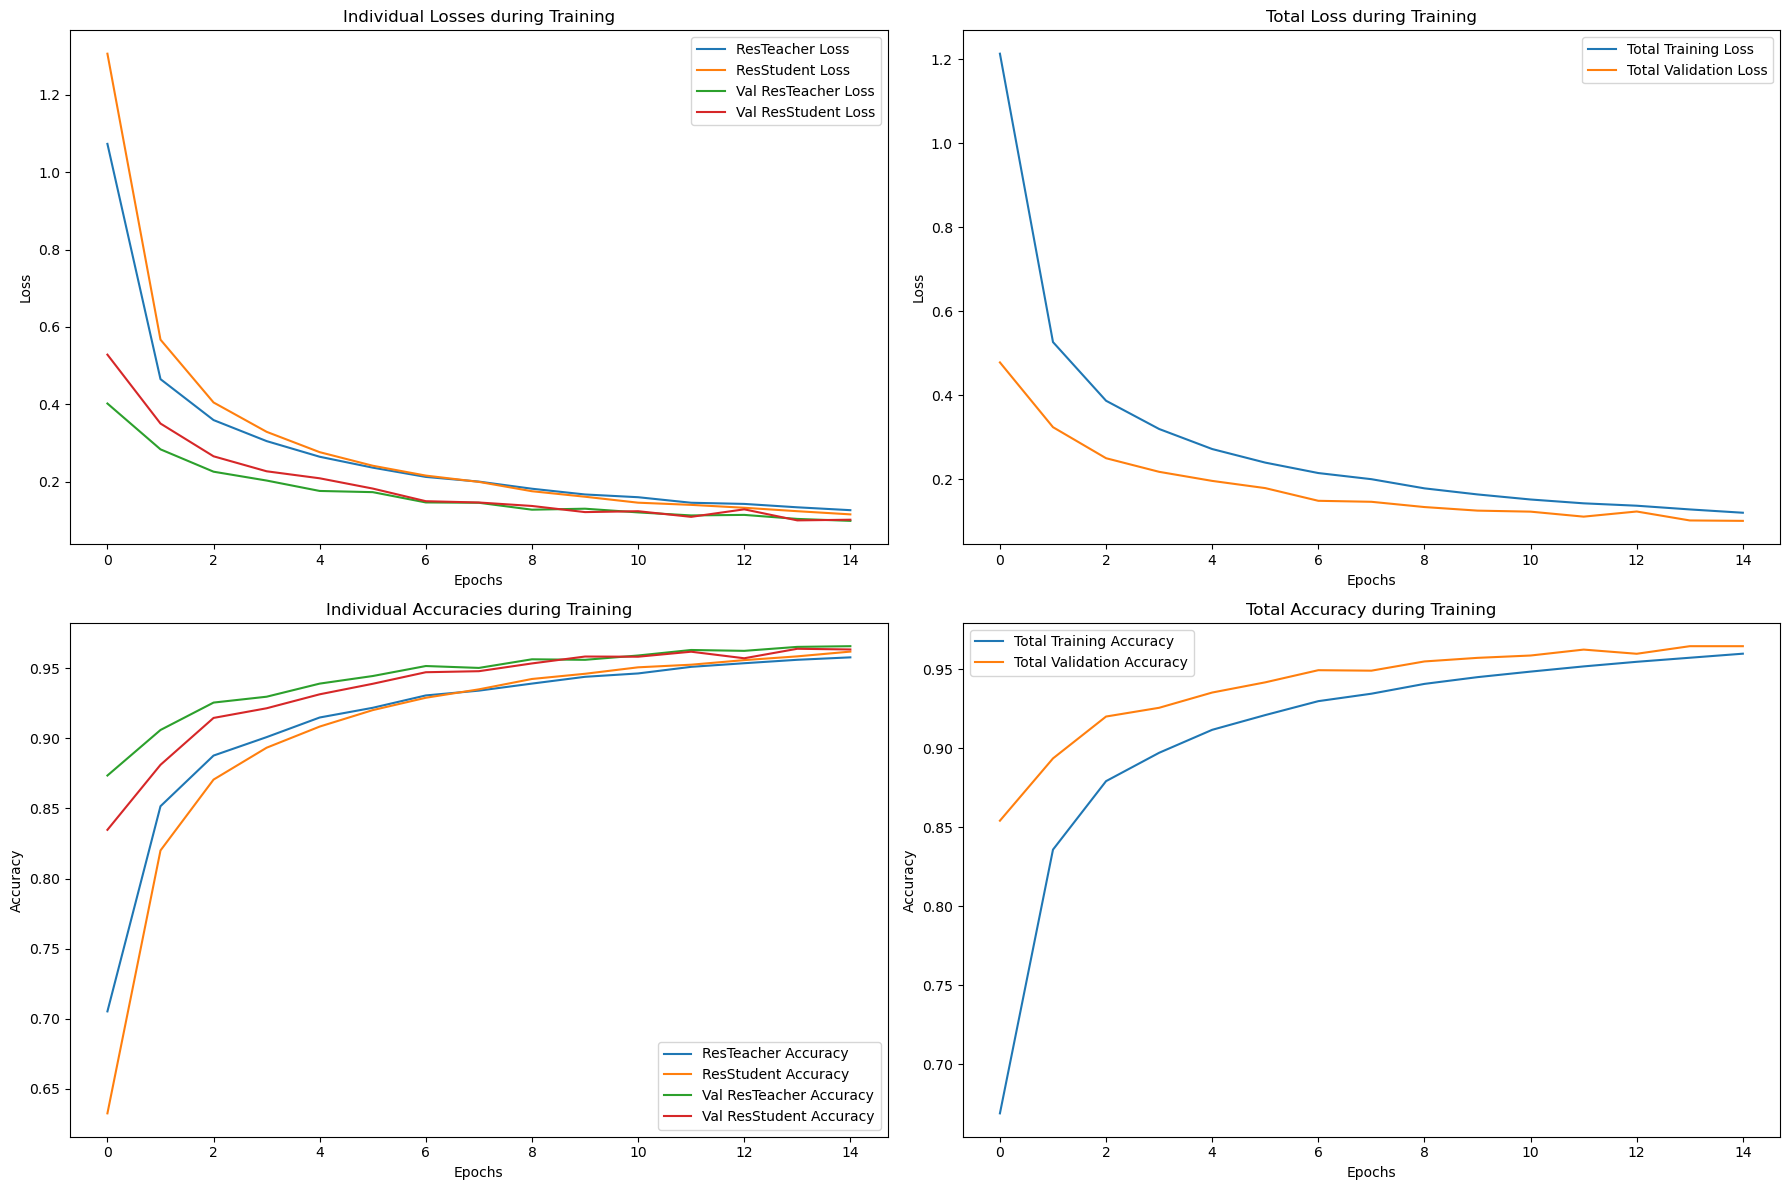

In [27]:
# Visualize training results
plt.figure(figsize=(18, 12))

# 1. Individual Losses (ResTeacher and ResStudent)
plt.subplot(2, 2, 1)
plt.plot(history.history['out1_loss'], label='ResTeacher Loss')
plt.plot(history.history['out2_loss'], label='ResStudent Loss')
plt.plot(history.history['val_out1_loss'], label='Val ResTeacher Loss')
plt.plot(history.history['val_out2_loss'], label='Val ResStudent Loss')
plt.title('Individual Losses during Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 2. Total Loss (Combined)
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Total Training Loss')
plt.plot(history.history['val_loss'], label='Total Validation Loss')
plt.title('Total Loss during Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 3. Individual Accuracies (ResTeacher and ResStudent)
plt.subplot(2, 2, 3)
plt.plot(history.history['out1_accuracy'], label='ResTeacher Accuracy')
plt.plot(history.history['out2_accuracy'], label='ResStudent Accuracy')
plt.plot(history.history['val_out1_accuracy'], label='Val ResTeacher Accuracy')
plt.plot(history.history['val_out2_accuracy'], label='Val ResStudent Accuracy')
plt.title('Individual Accuracies during Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 4. Total Accuracy (Averaged)
plt.subplot(2, 2, 4)
total_train_accuracy = (np.array(history.history['out1_accuracy']) + np.array(history.history['out2_accuracy'])) / 2
total_val_accuracy = (np.array(history.history['val_out1_accuracy']) + np.array(history.history['val_out2_accuracy'])) / 2
plt.plot(total_train_accuracy, label='Total Training Accuracy')
plt.plot(total_val_accuracy, label='Total Validation Accuracy')
plt.title('Total Accuracy during Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


## Conclusion and Next Steps

In this notebook, we configured and trained the ResTS model for plant disease classification. The model weights were saved for further testing and visualization of predictions. Next steps include:
- Testing the model on the test set.
- Applying explainability techniques to analyze which areas of the images the model focuses on for its predictions.